In [44]:
import sys, numpy as np, pandas as pd, matplotlib, sklearn
from sklearn.datasets import load_iris

np.random.seed(42)

iris = load_iris(as_frame=True)
X = iris.data
y = iris.target
clases = iris.target_names

df = X.copy()
df["target"] = y.map(dict(enumerate(clases)))

display(df.head())
display(df.groupby("target").agg(["mean", "std", "min", "max"]))
print("Clases:", list(clases))
print("Forma x: ", X.shape, "y: ", y.shape)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


sepal length (cm)                     sepal width (cm)            \
                        mean       std  min  max             mean       std   
target                                                                        
setosa                 5.006  0.352490  4.3  5.8            3.428  0.379064   
versicolor             5.936  0.516171  4.9  7.0            2.770  0.313798   
virginica              6.588  0.635880  4.9  7.9            2.974  0.322497   

                     petal length (cm)                     petal width (cm)  \
            min  max              mean       std  min  max             mean   
target                                                                        
setosa      2.3  4.4             1.462  0.173664  1.0  1.9            0.246   
versicolor  2.0  3.4             4.260  0.469911  3.0  5.1            1.326   
virginica   2.2  3.8             5.552  0.551895  4.5  6.9            2.026   

                                
                 std  min  max  
target                          
setosa      0.105386  0.1  0.6  
versicolor  0.197753  1.0  1.8  
virginica   0.274650  1.4  2.5

Clases: ['setosa', 'versicolor', 'virginica']
Forma x:  (150, 4) y:  (150,)


# Segun las medidas y desviaciones, ¿qué rasgos del pétalo parecen separar mejor las clases?

- El mas claro es el ancho del petalo ya que hay bastante diferencia en la media entre las tres variantes
- En el largo del sepalo tambien hay diferencia pero algo menos que en el petalo
- Tambien el ancho del sepalo de las setosas es bastante mas pequeño que el de las otras dos
  

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=42, stratify=y)

# Si no estratificas los datos, ¿qué podría ocurrir con una clase minoritaria? Explica por qué eso haría que la métrica de accuracy fuese menos representativa

Si no se dividen los datos en entrenamiento y test estariamos probando el modelo con los mismos datos con los que lo hemos entenado por lo que podria suceder:
- Un Overfeeting ya que se aprende todos los datos
- Que cuando se pruebe con otros datos distintos que esten fuera del dataset inicial no sea preciso 

Acuracy (Naive Bayes, test): 0.911
Reporte: 
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.87        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



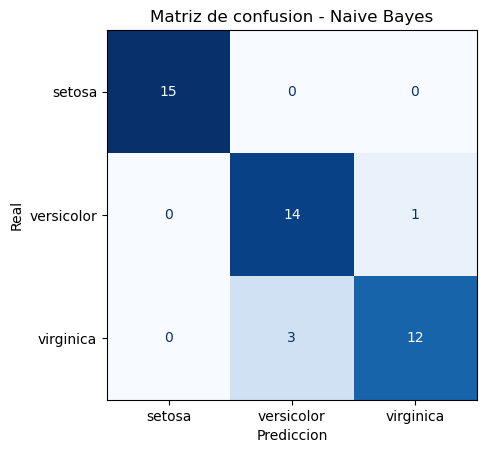

In [46]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pylab as plt

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)
cm_nb = confusion_matrix(y_test, y_pred_nb)

print(f"Acuracy (Naive Bayes, test): {acc_nb:.3f}")
print("Reporte: ")
print(classification_report(y_test, y_pred_nb, target_names=clases))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=clases)
fig, ax = plt.subplots()
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Matriz de confusion - Naive Bayes")
ax.set_xlabel("Prediccion")
ax.set_ylabel("Real")
plt.tight_layout
plt.show()

# Mira la matriz de confusión ¿qué pares de clases se confunden más? ¿Qué te sugiere sobre la separabilidad de essas clases con estos rasgos?

- Las clases que mas se confunden son las virginicas con las versicolor 
- Me sugiere que suele ser facil de distinguir entre los distintos tipos que hay

In [47]:
train_df = pd.DataFrame(X_train, columns=iris.feature_names)
train_df["y"] = y_train

def tri(x, a, b, c):
    return np.maximum(0, np.minimum((x - a) / (b - a + 1e-9), (c - x) / (c - b + 1e-9)))

def trap(x, a, b, c, d):
    left = (x - a) / (b - a + 1e-9)
    right = (d - x) / (d - c + 1e-9)
    return np.maximum(0, np.minimum(np.minimum(left, 1.0), np.minimum(right, 1.0)))

PL_IDX, PW_IDX, SW_IDX = 2, 3, 1
class_ids = [0, 1, 2]

def p10_50_90(vals):
    p10, p50, p90 = np.percentile(vals, [10, 50, 90])
    return p10, p50, p90, vals.min(), vals.max()

ranges = {}
for c in class_ids:
    sub = train_df[train_df["y"] == c]
    pl_vals = sub.iloc[:, PL_IDX].values
    pw_vals = sub.iloc[:, PW_IDX].values
    sw_vals = sub.iloc[:, SW_IDX].values
    pl10, pl50, pl90, pl_min, pl_max = p10_50_90(pl_vals)
    pw10, pw50, pw90, pw_min, pw_max = p10_50_90(pw_vals)
    sw10, sw50, sw90, sw_min, sw_max = p10_50_90(sw_vals)
    ranges[c] = dict(pl=(pl10, pl50, pl90, pl_min, pl_max), 
                     pw=(pw10, pw50, pw90, pw_min, pw_max),
                     sw=(sw10, sw50, sw90, sw_min, sw_max))

def mu_pl_c(x, c):
    p10, p50, p90, pmin, pmax = ranges[c]["pl"]
    a = max(pmin, p10 - 0.2 * (p50 - p10))
    b = p10
    c_ = p90
    d = min(pmax, p90 + 0.2 * (p90 - p50))
    return trap(x, a, b, c_, d) 

def mu_pw_c(x, c):
    p10, p50, p90, pmin, pmax = ranges[c]["pw"]
    a = max(pmin, p10 - 0.2 * (p50 - p10))
    b = p10
    c_ = p90
    d = min(pmax, p90 + 0.2 * (p90 - p50))
    return trap(x, a, b, c_, d) 

def mu_sw_c(x, c):
    p10, p50, p90, pmin, pmax = ranges[c]["sw"]
    a = max(pmin, p10 - 0.2 * (p50 - p10))
    b = p10
    c_ = p90
    d = min(pmax, p90 + 0.2 * (p90 - p50))
    return trap(x, a, b, c_, d) 

Accuracy (Fuzzy, test): 0.756


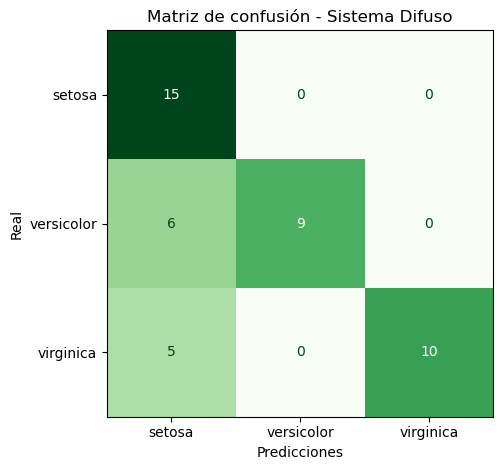

In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def score_class(pl_val, pw_val, sw_val, c):
    return np.minimum.reduce([mu_pl_c(pl_val, c), mu_pw_c(pw_val, c), mu_sw_c(sw_val, c)])

def predict_fuzzy(Xmat):
    preds = []
    for row in Xmat:
        pl_val, pw_val, sw_val = row[PL_IDX], row[PW_IDX], row[SW_IDX]
        scores = [score_class(pl_val, pw_val, sw_val, c) for c in class_ids]
        preds.append(int(np.argmax(scores)))
    return np.array(preds)

y_pred_fz = predict_fuzzy(X_test)
acc_fz = accuracy_score(y_test, y_pred_fz)
cm_fz = confusion_matrix(y_test, y_pred_fz)

print(f"Accuracy (Fuzzy, test): {acc_fz:.3f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_fz, display_labels=clases)
fig, ax = plt.subplots()
disp.plot(ax=ax, cmap="Greens", colorbar=False)
ax.set_title("Matriz de confusión - Sistema Difuso")
ax.set_xlabel("Predicciones")
ax.set_ylabel("Real")
plt.tight_layout()
plt.show()


# Compara las matrices NB y Difuso: ¿ves patrones distintos de error (qué claes confunden cada uno)? ¿Cúal te parece más explicabe o justificable y por qué?

- Si, hay diferencias entre estos dos tipos de matrices:
  - La matriz NB confunde más la versicolores con las virgínicas
  - La matriz del sistema Difuso confunde mas las setosas con las virgínicas y versicolor
- Me parece mas explicable la matriz NB ya que hicimos un reporte para explicar la precisión que había tenido nuestro modelo.

In [49]:
X_test_noisy = X_test.copy()
noise_std = 0.10
X_test_noisy[:, 3] = X_test_noisy[:, 3]+ np.random.normal(0, noise_std, size=X_test_noisy.shape[0])

y_pred_nb_noisy = nb.predict(X_test_noisy)
y_pred_fz_noisy = predict_fuzzy(X_test_noisy)

print("Accuracy NB (noisy):", accuracy_score(y_test, y_pred_nb_noisy))
print("Accuracy FZ (noisy):", accuracy_score(y_test, y_pred_fz_noisy))

Accuracy NB (noisy): 0.8888888888888888
Accuracy FZ (noisy): 0.7333333333333333


# ¿Cúal de los dos métodos se degrada más con un ruido y por qué podría ocurrir? Propón una mejora para el difuso

- Se degradan exactamente lo mismo los dos, el método NB sin ruido 0.91, con ruido 0.88 y el difuso sin ruido 0.8 y con ruido 0.77, hay una diferencia de 0.03 en ambos casos
- El sistema Difuso se podría ajustar mas por ejemplo acotando un poco más los percentiles y usando p20 p50 p80 por ejemplo, para que asi los outliners afecten menos al modelo, o todo lo contrario y porbaro con p5 p50 p95 para ver si habiendo mas outliner ayudan al modelo a ajustarse mejor.

# Tabla resumen

| Modelo | ACC. (limpio) | ACC (ruido) | Clases más confundidas | Observaciones |
|----------|-----------|-----------|-----------|-----------|
| Naive Bayes | 0.91  | 0.88  | versicolor seguida de virginica | Creo que este modelo es más eficiente, a aparte de ser más rápido es mas preciso |
| Sistema Difuso | 0.80  | 0.77  | setosa que la confunde con versicolor y virginica | Este sisteama creo que funcionaría mejor si hubiera menos datos en comparcion con el otro modelo |


# ¿En qué escenarios prácticos preferirías Naive Bayes frente al sistema difuso, y viceversa?
### Argumenta considerando interpretabilidad, rapidez de entrenamiento/inferencia, coantdidad de datos, supodiciones del modelo y sensibilidad al ruido.

- Usaria Naive Bayes si:
  - Hay muchos datos y el modelo tiene que ser rápido
  - No importa la interpretabilidad
  - Los datos tienen algo de ruido
- Usaría un sistema difuso si:
  - Se necesita explicar las decisiones
  - Hay pocos datos
  - Si se quiere controlar la lógica manualmente 

# Preguntas de investigación
## 1. ¿Por qué se llama "Naive" Bayes?

- Por que naive significa ingenua y este modelo hace una suposicion muy ingenua de los datos.
- Este modelo asume que todas las caracteristicas son independientes entre si.
- Se considera una simplificación fuerte por qu een realidad en la mayoría de casos la variables no son independientes entre si.
- Aun sabiendo esto, este modelo funciona sorprendentemente bien por la sisguientes razones:
  - No necesita probabilidades exactas, solo comparar las clases
  - La correlación no siempre afecta a la decisión final
  - Evita los sobreajustes
  

In [54]:
df.corr(numeric_only=True)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


Hay bastantes datos que si que son independientes entre si, minetras que otros como el ancho y el largo del petalo mantienen una gran correlación

## 2. Distribuciones gaussianas

- cada rasgo sigue una distribucion normal dentro de cada calse ya eu el sistema GaussianNB asume que si tomas todos los valores de un rasgo dentro de una misma calse, la distribucion de esos valores formaran una campana de Gauss
- La formula de la probabilidad segun gauss es esta :
  
$$
P(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \; e^{-\frac{(x - \mu)^2}{2\sigma^2}}
$$



<Axes: xlabel='petal width (cm)', ylabel='Density'>

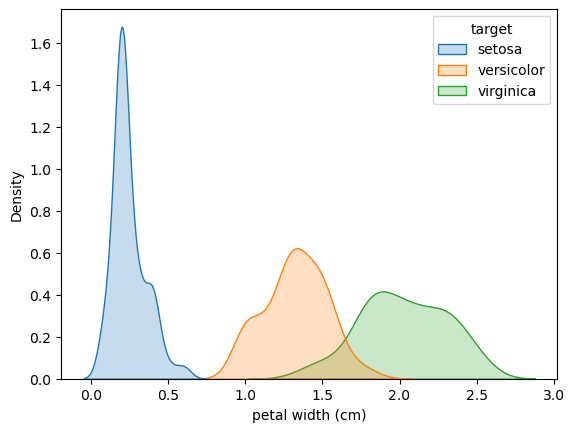

In [55]:
import seaborn as sns
sns.kdeplot(data=df, x="petal width (cm)", hue="target", fill=True)

La setosa no se solapa con ningua otra, mientras que la versicolor , con la virginica si que se solapas, por lo que podría producir errores a la hora de intentar clasificar algunas de ellas.

## 3. Interpretabilidad y reglas difusas

Un sistema difusose basa en reglas explicitas que relacionan los datos mediate logíca humana:
  
Si la temperatura es alta y l ahumedad es baja, ENTONCES enciendo el ventilador

Minetras que un modelo probabilistico calcula las probabilidades y elige la clase más probable.

In [56]:
ejemplo = X_test[0]
for c in class_ids:
    print(clases[c], mu_pl_c(ejemplo[2], c), mu_pw_c(ejemplo[3], c))

setosa 0.0 0.0
versicolor 0.0 0.0
virginica 1.0 0.9999999833333336


## 4. Sensibilidad al ruido

In [57]:
X_test_noisy = X_test.copy()
noise_std = 0.10
X_test_noisy[:, 2] = X_test_noisy[:, 2]+ np.random.normal(0, 0.10, size=X_test_noisy.shape[0])

y_pred_nb_noisy = nb.predict(X_test_noisy)
y_pred_fz_noisy = predict_fuzzy(X_test_noisy)

print("Accuracy NB (noisy):", accuracy_score(y_test, y_pred_nb_noisy))
print("Accuracy FZ (noisy):", accuracy_score(y_test, y_pred_fz_noisy))

Accuracy NB (noisy): 0.9111111111111111
Accuracy FZ (noisy): 0.7333333333333333


Se nota mas la caida del ruido en el sistema difuso, ya que el sistema de Naive Bayes en este caso no tendría ningun tipo de variación con respecto al que hicimos anteriormente sin ruido

## 5. Ampliación del sistema difuso

Cambiamos el metodo `score_class()` por esto:

```pyhton

def score_class(pl_val, pw_val, sw_val, c):
    return np.minimum.reduce([mu_pl_c(pl_val, c), mu_pw_c(pw_val, c), mu_sw_c(sw_val, c)])
```
y hacemos los cambios correspondiesntes en otros metodos para que pueda funcionar y observamos que:

- El accuracy altual (0.756) es menor que el anterior (0.80) al meter una nueva variable

## 6. Aplicaciones reales

Naive Bayes: filtrado de correos de spam

- Se aplica este modelo por las siguientes razones:
  - Mayor velocidad
  - Alta dimensionalidad
  - Es simple de ajustar y mantener
  
Sistema Difuso: control de sistemas industriales

- Se aplica este modelo por las siguientes razones:
  - Robusted y tolerancia al ruido
  - No necesita un modelo matemático exacto
  - Las reglas estan establecidas por humanos, facilita la compresión